In [ ]:
from IPython.display import display, Math, Latex, HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os

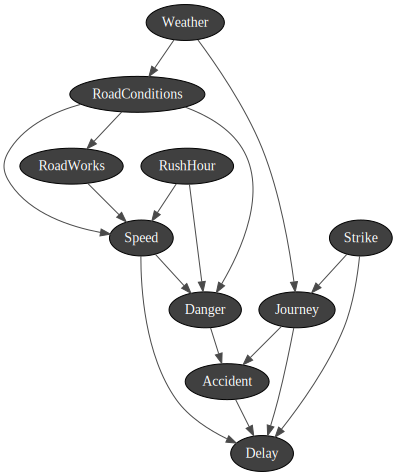

True

In [103]:
#construct network
m0 = gum.fastBN("Journey{True|False}<-Weather{Good|Bad}->RoadConditions{Good|Bad}->RoadWorks{True|False}->Speed{Slow|Fast};"
                "Speed->Delay{True|False}<-Accident{True|False}<-Journey->Delay<-Strike{True|False}->Journey;"
                "Speed<-RoadConditions->Danger{Low|High}<-RushHour{True|False}->Speed->Danger->Accident")


gnb.showBN(m0, size=10)
graph = gnb.BN2dot(m0, size=100)
graph.write_pdf('network.pdf')

In [ ]:
def common_data(list1, list2): 
    result = False
    # traverse in the 1st list 
    for x in list1: 
        # traverse in the 2nd list 
        for y in list2: 
            # if one common 
            if x == y: 
                result = True
                return result 


def getAncestors(cm,varSet):
    ancestors=varSet

    while len(varSet)>0:
        newparents=cm.parents(varSet[0])
        newparents = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, newparents) for i in b]
        newparents = [cm.names()[i] for i in newparents] 
        ancestors=ancestors+newparents
        varSet=varSet+newparents
        varSet.remove(varSet[0])
    return(ancestors)


def dSeparation(cm, varSet1, varSet2, evs):
    cmcopy=gum.fastBN("A")
    cmcopy.erase("A")
    [ cmcopy.add(name, 2) for name in cm.names()]
    for link in cm.arcs():
        cmcopy.addArc(*link)
    l1=cmcopy.names()
    l2=getAncestors(cmcopy,varSet1+varSet2+evs)
    #print(l2)
    l3 = [x for x in l1 if x not in l2]
    for i in l3:
        cmcopy.erase(i)
    m=cmcopy.moralGraph()
    if len(evs)>0:
        for i in evs:
            m.eraseNode(cmcopy.idFromName(i))
    #gnb.sideBySide(m)
    connComp=m.connectedComponents()
    #print(connComp)
    idVarSet1=[]
    idVarSet2=[]
    for i in varSet1:
        idVarSet1.append(cmcopy.idFromName(i))
    for i in varSet2:
        idVarSet2.append(cmcopy.idFromName(i))
    dSeparated=True
    for i in connComp:
        connCompSet=connComp[i]
        connCompSet= [i for b in map(lambda x:[x] if not isinstance(x, list) else x, connCompSet) for i in b]
        if common_data(connCompSet, idVarSet1) and common_data(connCompSet, idVarSet2):
            dSeparated=False
    del cmcopy
    return dSeparated


D-separation


In [ ]:
print(dSeparation(m0,["RushHour"], ["RoadConditions"], []))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Danger"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Speed"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Strike"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Weather"]))

In [ ]:
print(dSeparation(m0,["RushHour"], ["Strike"], []))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Delay"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Journey"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Danger"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Accident"]))

In [ ]:
print(dSeparation(m0,["Speed"], ["Accident"], []))

In [ ]:
print(dSeparation(m0,["RoadConditions"], ["Strike"], []))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Weather"]))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Journey"]))

In [ ]:
print(dSeparation(m0,["RoadWorks"], ["Strike"], []))
print(dSeparation(m0,["RoadWorks"], ["Strike"], ["Weather"]))
print(dSeparation(m0,["RoadWorks"], ["Strike"], ["Danger"]))
print(dSeparation(m0,["RoadWorks"], ["Strike"], ["Journey"]))

Conditional probability tables

In [ ]:
m0.cpt("Weather")[:]=[0.5, 0.5]
m0.cpt("Strike")[:]=[0.1, 0.9]
m0.cpt("RushHour")[:]=[0.2, 0.8]
# m0.cpt("Z")[{'X':'A','Y':'A'}]=[0,0.5,0.5]
# m0.cpt("Z")[{'X':'B','Y':'B'}]=[0.5,0,0.5]
# m0.cpt("Z")[{'X':'C','Y':'C'}]=[0.5,0.5,0] 
# m0.cpt("Z")[{'X':'A','Y':'B'}]=[0,0,1]
# m0.cpt("Z")[{'X':'A','Y':'C'}]=[0,1,0]
# m0.cpt("Z")[{'X':'B','Y':'A'}]=[0,0,1] 
# m0.cpt("Z")[{'X':'B','Y':'C'}]=[1,0,0]
# m0.cpt("Z")[{'X':'C','Y':'A'}]=[0,1,0]
# m0.cpt("Z")[{'X':'C','Y':'B'}]=[1,0,0]



#to draw network and cpt
# gnb.sideBySide(m0,m0.cpt("X"),m0.cpt("Y"),m0.cpt("Z"))